In [367]:
import geopandas as gpd
import os
import pandas as pd
import yaml
import numpy as np
from shapely.geometry import Point

In [368]:
import pathlib

In [369]:
base_dir = pathlib.Path("/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure")
gem_files = list(base_dir.rglob("Global*Tracker*.xlsx"))
gem_files

[PosixPath('/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Gas-Plant-Tracker-GGPT-February-2023-v2.xlsx'),
 PosixPath('/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Solar-Power-Tracker-May-2023.xlsx'),
 PosixPath('/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Coal-Plant-Tracker-July-2023.xlsx'),
 PosixPath('/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Coal-Plant-Tracker-add-CHP.xlsx'),
 PosixPath('/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Wind-Power-Tracker-May-2023.xlsx'),
 PosixPath('/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/gem_data_raw/Global-integrated-Plant-Tracker-July-2025_china.xlsx')]

In [370]:
import requests

urls = {
    # "coal": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Coal-Plant-Tracker-July-2025.xlsx",
    # "gas": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Gas-Plant-Tracker-July-2025.xlsx",
    # "wind": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Wind-Plant-Tracker-July-2025.xlsx",
    # "solar": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Solar-Plant-Tracker-July-2025.xlsx",
    # "hydro": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Hydro-Plant-Tracker-July-2025.xlsx",
    # "nuclear": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Nuclear-Plant-Tracker-July-2025.xlsx",
    # "biomass": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Bioenergy-Plant-Tracker-July-2025.xlsx",
    "integrated": "https://globalenergymonitor.org/wp-content/uploads/2025/07/Global-Integrated-Power-July-2025.xlsx"
}            
    
download_dir = pathlib.Path("../../resources/data/existing_infrastructure/gem_data_raw")
download_dir.mkdir(parents=True, exist_ok=True)

for tech in urls:
    url = urls[tech]
    filename = download_dir / f"Global-{tech}-Plant-Tracker-July-2025.xlsx"
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {url} (status code: {response.status_code})")

Downloaded ../../resources/data/existing_infrastructure/gem_data_raw/Global-integrated-Plant-Tracker-July-2025.xlsx


In [371]:
nodes = gpd.read_file("/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/derived_data/regions/provinces_onshore.geojson")
# nodes_offshore = gpd.read_file("/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/derived_data/regions/provinces_offshore.geojson")
# nodes.dropna(how="all", axis=1, inplace=True)
t = "/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Coal-Plant-Tracker-July-2023.xlsx"


In [372]:
import logging
logger = logging.getLogger("devgem")

In [373]:
import requests
import zipfile
import io

def fetch_gadm(country_code="CHN", level=2):
    """
    fetch GADM shapefile for a given country and administrative level.
    https://gadm.org/download_country.html

    Parameters:
        country_code (str): ISO3 country code (e.g., 'CHN', 'USA').
        level (int): Administrative level (0=country, 1=region, etc.).

    Returns:
        geopandas.GeoDataFrame: Loaded shapefile as GeoDataFrame.
    """
    # Construct the URL
    url = f"https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_{country_code}_shp.zip"

    # Download the zip file
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(
            f"Failed to download data for {country_code} - Status code: {response.status_code}"
        )

    # Extract the zip file in memory
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Filter to the desired level shapefile
        level_filename = f"gadm41_{country_code}_{level}.shp"
        if level_filename not in z.namelist():
            raise ValueError(f"Level {level} shapefile not found for {country_code}.")

        shp_dir = "resources/data/province_shapes"
        z.extractall(shp_dir)
        gdf = gpd.read_file(f"{shp_dir}/{level_filename}")
        return gdf


def fetch_prefecture_shapes(
    fixes={
        "NAME_1": {
            "Nei Mongol": "InnerMongolia",
            "Xinjiang Uygur": "Xinjiang",
            "Hong Kong": "HongKong",
            "Ningxia Hui": "Ningxia",
        }
    }
):
    """
    Fetch county-level shapefiles for China.

    Args:
        fixes (dict, Optional): Dictionary mapping old names to new names for specific columns.
    """
    gdf = fetch_gadm(country_code="CHN", level=2)
    for col, fix_dict in fixes.items():
        for old_name, new_name in fix_dict.items():
            mask = gdf.query(f"{col} == '{old_name}'").index
            gdf.loc[mask, col] = new_name
    return gdf


def build_provinces_with_split_inner_mongolia(
    prefectures: gpd.GeoDataFrame,
    east_prefs=["Hulunbuir", "Xing'an", "Tongliao", "Chifeng", "Xilin Gol"],
    west_prefs=[
        "Alxa",
        "Baotou",
        "Baynnur",
        "Hohhot",
        "Ordos",
        "Ulaan Chab",
        "Wuhai",
    ],
) -> gpd.GeoDataFrame:
    """
    Split Inner Mongolia into East and West regions based on predefined prefectures.

    Args:
        prefectures (gpd.GeoDataFrame): Gall chinese prefectures.
        east_prefs (list, optional): List of prefectures in Inner Mongolia East.
        west_prefs (list, optional): List of prefectures in Inner Mongolia West.
    Returns:
        gpd.GeoDataFrame: Updated GeoDataFrame with Inner Mongolia split EAST/WEST.
    """
    gdf = prefectures.copy()
    
    if not (set(east_prefs) & set(west_prefs) == set()):
        raise ValueError("East and West prefecture lists must not overlap.")
    all_prefs = sorted(east_prefs + west_prefs)
    if not all_prefs == sorted(gdf.query("NAME_1 == 'InnerMongolia'").NAME_2.unique().tolist()):
        raise ValueError(
            f"Inner Mongolia prefectures do not match expected: \n{all_prefs}\n vs\n {gdf.query('NAME_1 == \"InnerMongolia\"').NAME_2.unique().tolist()}"
        )
    split = {
        prefecture: "InnerMongoliaEast" if prefecture in east_prefs else "InnerMongoliaWest"
        for prefecture in gdf.query("NAME_1 == 'InnerMongolia'").NAME_2
    }
    mask = gdf.query("NAME_1 == 'InnerMongolia'").index
    gdf.loc[mask, "NAME_1"] = gdf.loc[mask, "NAME_2"].map(split)
    return gdf.dissolve(by="NAME_1", aggfunc="sum")

inner_mongolia = {
    "InnerMongoliaWest": ["Hulunbuir", "Xing'an", "Tongliao", "Chifeng", "Xilin Gol"],
    "InnerMongoliaEast": [
        "Alxa",
        "Baotou",
        "Baynnur",
        "Hohhot",
        "Ordos",
        "Ulaan Chab",
        "Wuhai",
    ],}
# TODO check no overlap
im_mongolia_map = {vv: k  for k in inner_mongolia for vv in inner_mongolia[k]}

In [374]:
prefs = fetch_prefecture_shapes()


In [375]:
provinces = build_provinces_with_split_inner_mongolia(prefs)

In [430]:
def load_gem_excel(path: os.PathLike, sheetname = "Units", country_col = "Country/area", country_names = ["China"])-> pd.DataFrame:
    """
    Load a Global Energy monitor excel file as a dataframe.

    Args:
        path (os.PathLike): Path to the Excel file.
        sheetname (str): Name of the sheet to load. Default is "Units".
        country_col (str): Column name for country names. Default is "Country/area".
        country_names (list): List of country names to filter by. Default is ["China"].
    """

    df = pd.read_excel(path, sheet_name=sheetname, engine="openpyxl")
    df.columns = df.columns.str.replace("/", "_")
    country_col = country_col.replace("/", "_")
    if not country_col in df.columns:
        logger.warning(f"Column {country_col} not found in {path}. Returning unfiltered DataFrame.")
        return df
    return df.query(f'{country_col} in @country_names')

def partition_gem_across_nodes(gem_data: pd.DataFrame, nodes: gpd.GeoDataFrame, admin_level = None) -> pd.DataFrame:
    """
    Partition GEM data across nodes based on geographical coordinates.

    Args:
        gem_data (pd.DataFrame): DataFrame containing GEM data.
        nodes (geopandas.GeoDataFrame): GeoDataFrame containing node geometries (nodes as index).
        admin_level (int, optional): Administrative level for partitioning. Default is None (GPS).

    Returns:
        pd.DataFrame: DataFrame with GEM data partitioned across nodes.
    """
    ADM_COL = {0:"Country", 1:'Subnational unit (province, state)', 2: 'Major area (prefecture, district)'}
    if admin_level is not None and admin_level not in [0, 1, 2]:
        raise ValueError("admin_level must be None, 0, 1, or 2")

    # snap to admin_level
    if admin_level is not None:
        admin = ADM_COL[admin_level]
        gem_data[admin] = gem_data[admin].str.replace(" ", "")
        uncovered_gem = set(gem_data[ADM_COL[admin_level]]) - set(nodes.index)
        if uncovered_gem:
            logger.warning(
                f"Some GEM locations are not covered by the nodes at admin level {admin_level}: {uncovered_gem}"
                ". Consider partitioning with at a different admin_level or with GPS (None)."
            )
        gem_data["node"] = gem_data[admin]
        gem_data.dropna(subset=["node"], inplace=True)
        return gem_data
    else:
        gem_data["geometry"] = gem_data.apply(
            lambda row: Point(row["Longitude"], row["Latitude"]), axis=1
        )
        gem_gdf = gpd.GeoDataFrame(gem_data, geometry="geometry", crs="EPSG:4326")
        joined = nodes.reset_index(names="node").sjoin_nearest(gem_gdf, how="right")
        missing = joined[joined.node.isna()]
        if not missing.empty:
            logger.warning(
                f"Some GEM locations are not covered by the nodes at GPS: {missing["Plant name"].head()}"
            )
        return joined


In [732]:
gem_data_all = load_gem_excel("/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/gem_data_raw/Global-integrated-Plant-Tracker-July-2025_china.xlsx", sheetname="Power facilities")
datasets = {}
for tech in gem_data_all.Type.unique():   
    datasets[tech] = gem_data_all[gem_data_all.Type == tech]


In [379]:
def assign_year_bins(df: pd.DataFrame, year_bins: list) -> pd.DataFrame:
    """
    Assign a year bin to the existing capacities according to the config

    Args:
        df (pd.DataFrame): DataFrame with existing capacities and build years (DateIn)
        year_bins (list): years to bin the existing capacities to
    Returns:
        pd.DataFrame: DataFrame regridded to the year bins
    """

    df_ = df.copy()
    # bin by years (np.digitize)
    df_["grouping_year"] = np.take(year_bins, np.digitize(df.DateIn, year_bins, right=True))
    return df_.fillna(0)

In [384]:

def group_by_year(df: pd.DataFrame, year_bins: list, base_year = 2020) -> pd.DataFrame:
    """
    Group the DataFrame by year bins.

    Args:
        df (pd.DataFrame): DataFrame with a 'Start year' column.
        year_bins (list): List of year bins to group by.
        base_year (int): cut-off for histirocal period. Default is 2020.

    Returns:
        pd.DataFrame: DataFrame with a new 'grouping_year' column.
    """
    min_start_year = min(year_bins)-2.5
    base_year = 2020
    df = df[df["Start year"] > min_start_year]
    df = df[df["Retired year"].isna() | (df["Retired year"] > base_year)].reset_index(drop=True)
    df["grouping_year"] = np.take(year_bins, np.digitize(df["Start year"] , year_bins, right=True))

    return df

In [787]:
config_GEM = """
# map GEM Type based on technology
#       Type: technology: rename_to
# Set rename_to: null to drop
# default is a * wildcard (except pre-defined). 
CHP:
    split: true
    aliases: ["CHP", "cogeneration", "cogen", "heating", "heat"]
tech_map: 
    gas: 
        combined cycle: CCGT
        default: OCGT
    wind: 
        Onshore: onwind
        Offshore hard mount: offwind
        Offshore floating: offwind
    solar: 
        Solar Thermal: solar_thermal
        PV: solar
        default: null
    # tricky because some conventional is also PHS
    hydropower:
        pumped storage: PHS
        # run-of-river: ror
        default: hydro
        
# level of brownfield
base_year: 2020  # units retired before this date will be dropped
status:
    - operating
    - retired
    # - construction
# for more brownfield add `construction`, `pre-construction` and/or `announced`
relevant_columns:
    - "Type"
    - "Plant name"
    - "Technology"
    - "Fuel"
    - "Capacity (MW)"
    - "Start year"
    - "Retired year"
    - "Subregion"
    - "Region"
    - "Local area (taluk, county)"
    - "Major area (prefecture, district)"
    - "Subnational unit (state, province)"
    - "Status"
"""

gem_cfg = yaml.safe_load(config_GEM)

In [788]:
states = gem_cfg["status"]
GEM = gem_data_all.copy().query("Status in @states")
GEM.rename(columns={"Plant _ Project name": "Plant name"}, inplace=True)
GEM.loc[:, "Retired year"] = GEM["Retired year"].replace("not found", np.nan)
GEM.loc[:, "Start year"] = GEM["Start year"].replace("not found", np.nan)
GEM = GEM[gem_cfg["relevant_columns"]]
gas_mask = GEM.query("Type == 'oil/gas' & Fuel.str.contains('gas', case=False, na=False)").index
GEM.loc[gas_mask, "Type"] = "gas"
GEM.Type = GEM.Type.str.replace("bioenergy", "biomass")

if gem_cfg["CHP"].get("split", False):
    aliases = gem_cfg["CHP"]["aliases"]
    chp_mask = GEM[GEM["Plant name"].str.contains("chp", case=False, na=False)].index
    for alias in aliases:
        chp_mask = chp_mask.append(GEM[GEM["Plant name"].str.contains(alias, case=False, na=False)].index)
    chp_mask = chp_mask.unique()
    GEM.loc[chp_mask, "Type"] = "CHP "+ GEM.loc[chp_mask, "Type"]  


/tmp/ipykernel_228621/4000475048.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GEM.loc[:, "Start year"] = GEM["Start year"].replace("not found", np.nan)


In [790]:
GEM.Type.unique()

array(['nuclear', 'biomass', 'CHP biomass', 'gas', 'CHP gas', 'wind',
       'CHP wind', 'solar', 'CHP solar', 'hydropower', 'CHP coal', 'coal'],
      dtype=object)

In [791]:
GEM["tech"] = ""
for tech, mapping in gem_cfg["tech_map"].items():
    tech_mask = GEM.query(f"Type == '{tech}'").index
    if tech_mask.empty:

        continue

    if isinstance(mapping, str):
        raise ValueError(
            f"Mapping for {tech} is a string - expected dict"
        )
    
    GEM.loc[tech_mask, "Type"] = GEM.loc[tech_mask, "Technology"].map(mapping)

    if "default" not in mapping:
        continue
    
    fill_val = mapping["default"]
    if fill_val is not None:
        GEM.loc[tech_mask, "Type"] = GEM.loc[tech_mask, "Type"].fillna(value=fill_val)

    else:
        GEM.loc[tech_mask, "Type"] = GEM.loc[tech_mask, "Type"].dropna()

GEM.dropna(subset=["Type"], inplace=True)

In [792]:
years = [1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060]
cleaned = group_by_year(GEM, years, base_year=gem_cfg["base_year"])

In [793]:

datasets = {tech: cleaned[cleaned.Type == tech].copy() for tech in cleaned.Type.unique()}
for name, ds in datasets.items():
    df = ds.pivot_table(
    index="grouping_year",
    columns="Subnational unit (state, province)",
    values="Capacity (MW)",
    aggfunc="sum").fillna(0)
    # df.to_csv(f"{name}_existing_capacities.csv")
    #

In [801]:
datasets["coal"]["Capacity (MW)"].sum()

1130063.0

In [800]:
ds = datasets["CHP coal"]
mask = ds.query("`Plant name`.str.contains('heat', case=False, na=False)").index
ds.loc[mask, "Plant name"]

17839    Baitao Industrial Park Heat Island Center powe...
17840    Baitao Industrial Park Heat Island Center powe...
17912                Beihai New Area Heating power station
17913                Beihai New Area Heating power station
17914                Beihai New Area Heating power station
17915                Beihai New Area Heating power station
17916                Beihai New Area Heating power station
17917                Beihai New Area Heating power station
17918                Beihai New Area Heating power station
17919                Beihai New Area Heating power station
17950    Binzhou Huihong New Materials Co. Zhanhua Binh...
17951    Binzhou Huihong New Materials Co. Zhanhua Binh...
17952    Binzhou Huihong New Materials Co. Zhanhua Binh...
17953    Binzhou Huihong New Materials Co. Zhanhua Binh...
20419         Weiqiao Binzhou Public Heating power station
20420         Weiqiao Binzhou Public Heating power station
20421         Weiqiao Binzhou Public Heating power stati

In [796]:
msk = gem_data_all.query("Type=='oil/gas'")["Plant _ Project name"].str.contains("huizhou", case=False)
filtered = gem_data_all.query("Type=='oil/gas'").loc[msk]
filtered[["Start year", "Retired year", "Plant _ Project name", "Capacity (MW)"]]

,Start year,Retired year,Plant _ Project name,Capacity (MW)
4861,2024,NaN,Datang Guangdong Huizhou Boluo Gas Thermal pow...,460.0
4862,2025,NaN,Datang Guangdong Huizhou Boluo Gas Thermal pow...,460.0
5017,2026,NaN,Guangdong Huizhou New Material Industrial Park...,460.0
5018,2026,NaN,Guangdong Huizhou New Material Industrial Park...,460.0
5019,not found,NaN,Guangdong Huizhou Pinghai power plant,600.0
5020,not found,NaN,Guangdong Huizhou Pinghai power plant,600.0
5181,2024,NaN,Huadian Huizhou Dongjiang Gas cogeneration pow...,535.0
5182,2024,NaN,Huadian Huizhou Dongjiang Gas cogeneration pow...,535.0
5280,not found,NaN,Huaneng Guangdong Huizhou power station,120.0
5281,not found,NaN,Huaneng Guangdong Huizhou power station,120.0


In [797]:
datasets.keys()

dict_keys(['nuclear', 'biomass', 'CHP biomass', 'OCGT', 'CCGT', 'CHP gas', 'onwind', 'offwind', 'CHP wind', 'solar', 'solar_thermal', 'CHP solar', 'hydro', 'PHS', 'CHP coal', 'coal'])

In [798]:
ADM_COL = {0:"Country", 1:'Subnational unit (province, state)', 2: 'Major area (prefecture, district)'}
quick_v =  gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
quick_v["node"] = quick_v.apply(lambda row: row[ADM_COL[2]] if row[ADM_COL[1]] == 'InnerMongolia' else row[ADM_COL[1]], axis=1)
im_split = quick_v[ADM_COL[2]].map(im_mongolia_map).dropna()
quick_v.loc[im_split.index, "node"] = im_split

ValueError: Unknown column geometry

In [ ]:
df = load_gem_excel(t, sheetname="Units", country_names=["China"])
nodes.set_index("province", inplace=True)

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


KeyError: "None of ['province'] are in the columns"

In [ ]:
joined2 = partition_gem_across_nodes(df, provinces[['geometry', 'GID_2']], admin_level=None)

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


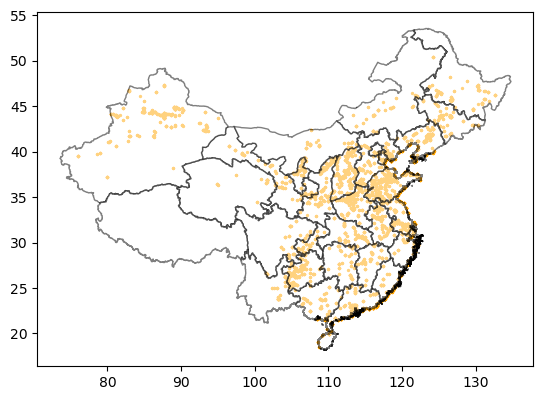

In [ ]:

not_inner = quick_v[~ quick_v.node.isin(["InnerMongoliaEast", "InnerMongoliaWest"])]
unmatched = not_inner[not_inner.node != not_inner["Subnational unit (province, state)"]]
ax = not_inner[not_inner.node == not_inner["Subnational unit (province, state)"]].plot(markersize=2, color ="orange")
provinces.plot(ax=ax, color="white", markersize=1, alpha=0.5, edgecolor='black')
if not unmatched.empty:
    unmatched.plot(markersize=10, ax =ax)
# Annotate unmatched points based on column "a"
col = "Subnational unit (province, state)"
if col in unmatched.columns:
    for idx, row in unmatched.iterrows():
        ax.annotate(str(row[col]), (row.geometry.x, row.geometry.y), fontsize=4, color="black")


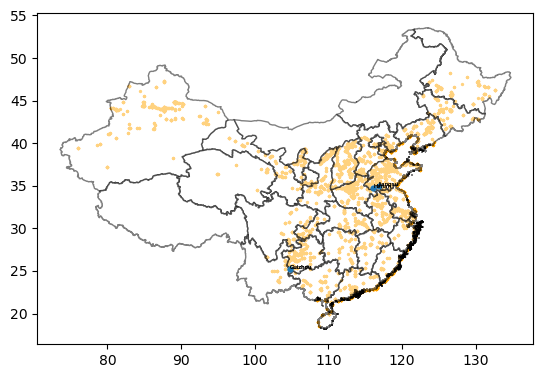

In [ ]:

not_inner = joined2[~ joined2.node.isin(["InnerMongoliaEast", "InnerMongoliaWest"])]
unmatched = not_inner[not_inner.node != not_inner["Subnational unit (province, state)"]]
ax = not_inner[not_inner.node == not_inner["Subnational unit (province, state)"]].plot(markersize=2, color ="orange")
provinces.plot(ax=ax, color="white", markersize=1, alpha=0.5, edgecolor='black')
unmatched.plot(markersize=10, ax =ax)
# Annotate unmatched points based on column "a"
col = "Subnational unit (province, state)"
if col in unmatched.columns:
    for idx, row in unmatched.iterrows():
        ax.annotate(str(row[col]), (row.geometry.x, row.geometry.y), fontsize=4, color="black")

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


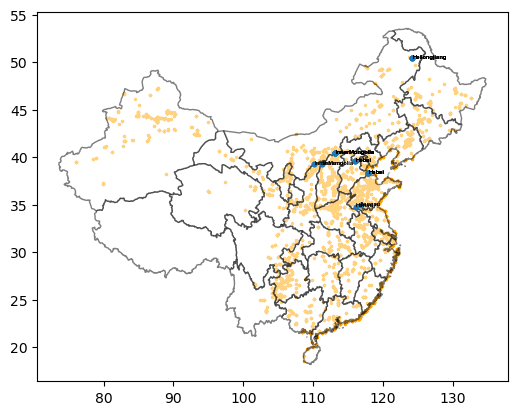

In [ ]:
df["Subnational unit (province, state)"] = df["Subnational unit (province, state)"].str.replace(" ", "")
joined = partition_gem_across_nodes(df, nodes, admin_level=None)
unmatched = joined[joined.node != joined["Subnational unit (province, state)"]]
ax = joined[joined.node == joined["Subnational unit (province, state)"]].plot(markersize=2, color ="orange")
nodes.plot(ax=ax, color="white", markersize=1, alpha=0.5, edgecolor='black')
unmatched.plot(markersize=10, ax =ax)
# Annotate unmatched points based on column "a"
col = "Subnational unit (province, state)"
if col in unmatched.columns:
    for idx, row in unmatched.iterrows():
        ax.annotate(str(row[col]), (row.geometry.x, row.geometry.y), fontsize=4, color="black")

In [ ]:
countries_names = ["CHA"]

def replace_natural_gas_technology(df: pd.DataFrame):
    """
    Maps and replaces gas technologies in the powerplants.csv onto model
    compliant carriers.
    """
    mapping = {
        "Steam Turbine": "CCGT",
        "Combustion Engine": "OCGT",
        "NG": "CCGT",
        "Ng": "CCGT",
        "NG/FO": "OCGT",
        "Ng/Fo": "OCGT",
        "NG/D": "OCGT",
        "LNG": "OCGT",
        "CCGT/D": "CCGT",
        "CCGT/FO": "CCGT",
        "LCCGT": "CCGT",
        "CCGT/Fo": "CCGT",
    }
    fueltype = df["Fueltype"] == "Natural Gas"
    df.loc[fueltype, "Technology"] = (
        df.loc[fueltype, "Technology"].replace(mapping).fillna("CCGT")
    )
    unique_tech_with_ng = df.loc[fueltype, "Technology"].unique()
    unknown_techs = np.setdiff1d(unique_tech_with_ng, ["CCGT", "OCGT"])
    if len(unknown_techs) > 0:
        df.loc[fueltype, "Technology"] = df.loc[fueltype, "Technology"].replace(
            {t: "CCGT" for t in unknown_techs}
        )
    df["Fueltype"] = np.where(fueltype, df["Technology"], df["Fueltype"])
    return df


# ppl_raw = pm.powerplants(from_url=True, update=True, config_update=config)
   